## create_figure_cumulative_edge_graph

In [1]:
import networkx as nx
import random
import collections
import numpy as np
import pandas as pd
import itertools
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import mpox_utils 

from mpox_utils import *


In [2]:
# Set all font sizes
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# This is a simplification of the the function that runs the simulation in mpox_utils. It is created to only add and 
#     update edges to save on computational time

def simulate_edges_only(seed, N, n_initial, steps):
    
    random.seed(seed)
    
    ############ Random Numbers
    mu_e = 7.6 #from Charniga 2022
    sigma_e = 4.9 #from Charniga 2022
    clip_e = (0 - mu_e)/sigma_e # calculate to clip at 0 (can't be infectious before exposed)
    mu_i = 27 # assumption, consistent with others (Spicknall 2022, Ogoina 2023)
    sigma_i = 3 # assumption, consistent with others (Spicknall 2022, Ogoina 2023)
    clip_i = (0-mu_i)/sigma_i # calculate to clip at 0 (can't recover before infectious)
    min_u = 0
    max_u = 14
    pcontact_main = 0.22
    pcontact_casual = 0.14
    pcontact_onetime = 1
    
    onetime_prob = [0.065/7, 0.087/7, 0.086/7, 0.056/7, 0.055/7, 0.055/7]
    activity_prob = [0, 0.001, 0.0054, 0.0101, 0.0315, 0.286]
    ##########
    
    ### Create graph
    G, total_degseq, main_degseq, onetime_degseq, rel_activity, activity_strat = CreateGraph(N, onetime_prob, activity_prob)
    
    ever_onetime = onetime_degseq
    
    G, main_relationships, casual_relationships, onetime_relationships = init_relationships(G, onetime_degseq, main_degseq, rel_activity)
    
    #### Set up lists that track things between time steps
    # First year, no main/casual relationships should be expired (so no prior relationships to avoid)
    want_main = []
    want_casual = []
    ex_list_main = [None]*N
    ex_list_casual = [None]*N

    num_edges = [len(list(G.edges()))]
    num_onetime = [len(onetime_relationships)]
    num_contacts = np.zeros(steps)    
    
    # randomly select 100 nodes to show
    track_nodes = random.sample(list(G.nodes()),50)#list(range(100))#
    
    degreeseq = [d for n, d in G.degree()]
    
    print(np.sum(degreeseq)/N)
    
    print(activity_strat[track_nodes])
    
    # Determine which edges are present at time 0
    edges_t0 = [(x,y,z) for (x,y,z) in G.edges(keys=True) if (x,y,z)[0] in track_nodes or (x,y,z)[1] in track_nodes and ((x,y,z)[0] != (x,y,z)[1])]
    dat_t0_1 = [(x,y,z,d) for (x,y,z,d) in G.edges(keys=True, data=True) if (x,y,z) in edges_t0]
    dat_t0 = set((x, y, z, tuple(d.items())) for (x, y, z, d) in dat_t0_1)
    edges_dat = dat_t0
    track_edges = set(edges_t0)
    
    
    for i in range(1,steps):   
       
        ### Relationship Updates
        G, onetime_relationships, onetime_degseq_new = update_onetimerelationships(G, onetime_relationships, onetime_prob, rel_activity, activity_prob, activity_strat)
        G, want_main, want_casual, ex_list_main, ex_list_casual = update_relationships(G, want_main, want_casual, ex_list_main, ex_list_casual)
        
        # Add any new edges to a list of cumulative edges
        track_edges_new = [(x,y,z) for (x,y,z) in G.edges(keys=True) if (x,y,z)[0] in track_nodes or (x,y,z)[1] in track_nodes and ((x,y,z)[0] != (x,y,z)[1])]
        track_edges = track_edges | set(track_edges_new)
        
        new_dat = [(x,y,z,d) for (x,y,z,d) in G.edges(keys=True, data=True) if (x,y,z) in track_edges]
        
        new_dat2 = set((x, y, z, tuple(d.items())) for (x, y, z, d) in new_dat)

        edges_dat = edges_dat | new_dat2
        
        
        if i == 1:
            edges_t1 = track_edges
            dat_t1 = edges_dat
        
        if i == 7:
            edges_t7 = track_edges
            dat_t7 = edges_dat
            
        if i == 14:
            edges_t14 = track_edges
            dat_t14 = edges_dat
            
        if i == 21:
            edges_t21 = track_edges
            dat_t21 = edges_dat
            
        if i == 28:
            edges_t28 = track_edges
            dat_t28 = edges_dat
            
        if i == 35:
            edges_t35 = track_edges
            dat_t35 = edges_dat
            
        if i == 42:
            edges_t42 = track_edges
            dat_t42 = edges_dat
            
        if i == 49:
            edges_t49 = track_edges
            dat_t49 = edges_dat
        
        
    return(G, track_nodes, edges_t0, edges_t1, edges_t7, edges_t14, edges_t21, edges_t28, edges_t35, edges_t42, edges_t49,
          dat_t0, dat_t1, dat_t7, dat_t14, dat_t21, dat_t28, dat_t35, dat_t42, dat_t49 )

In [4]:
# Get same list of random seeds each time
random.seed(1)
rand_seeds = random.sample(range(1000000), k = 1000)

seed_num = int(1)
print("SEED")
print(seed_num)
seed = rand_seeds[seed_num]

# Get other arguments
N = 10000
n_initial= 10
p_infect = 0.9
steps = 50

(G, track_nodes, edges_t0, edges_t1, edges_t7, edges_t14, edges_t21, edges_t28, edges_t35, edges_t42, edges_t49,
          dat_t0, dat_t1, dat_t7, dat_t14, dat_t21, dat_t28, dat_t35, dat_t42, dat_t49 ) = simulate_edges_only(seed, N, n_initial, steps)



SEED
1
0.6998
[3 1 4 4 1 2 2 3 2 0 0 3 4 1 4 4 4 1 4 2 0 5 2 4 1 3 1 1 4 2 2 3 3 2 0 4 3
 1 2 1 2 0 4 4 2 3 4 1 3 3]


In [6]:
## Create graph objects out of edge lists

G0 = nx.MultiDiGraph()  # Using a MultiDiGraph to allow edges with multiple keys (if needed)

# Add edges with attributes
for u, v, key, attributes in dat_t0:
    attr_dict = dict(attributes)  # Convert the attributes tuple into a dictionary
    G0.add_edge(u, v, key=key, **attr_dict)
    G0.add_nodes_from(track_nodes)
    
G1 = nx.MultiDiGraph()  # Using a MultiDiGraph to allow edges with multiple keys (if needed)

# Add edges with attributes
for u, v, key, attributes in dat_t1:
    attr_dict = dict(attributes)  # Convert the attributes tuple into a dictionary
    G1.add_edge(u, v, key=key, **attr_dict)
    G1.add_nodes_from(track_nodes)
    
G7 = nx.MultiDiGraph()  # Using a MultiDiGraph to allow edges with multiple keys (if needed)

# Add edges with attributes
for u, v, key, attributes in dat_t7:
    attr_dict = dict(attributes)  # Convert the attributes tuple into a dictionary
    G7.add_edge(u, v, key=key, **attr_dict)
    G7.add_nodes_from(track_nodes)
    
G14 = nx.MultiDiGraph()  # Using a MultiDiGraph to allow edges with multiple keys (if needed)

# Add edges with attributes
for u, v, key, attributes in dat_t14:
    attr_dict = dict(attributes)  # Convert the attributes tuple into a dictionary
    G14.add_edge(u, v, key=key, **attr_dict)
    G14.add_nodes_from(track_nodes)

G28 = nx.MultiDiGraph()  # Using a MultiDiGraph to allow edges with multiple keys (if needed)

# Add edges with attributes
for u, v, key, attributes in dat_t28:
    attr_dict = dict(attributes)  # Convert the attributes tuple into a dictionary
    G28.add_edge(u, v, key=key, **attr_dict)
    G28.add_nodes_from(track_nodes)
    
    
G49 = nx.MultiDiGraph()  # Using a MultiDiGraph to allow edges with multiple keys (if needed)

# Add edges with attributes
for u, v, key, attributes in dat_t49:
    attr_dict = dict(attributes)  # Convert the attributes tuple into a dictionary
    G49.add_edge(u, v, key=key, **attr_dict)
    G49.add_nodes_from(track_nodes)

In [7]:
# Define a function to count edges by type
def count_edge_types(G):
    main_count = sum(1 for u, v, k, e in G.edges(keys=True, data=True) if e['rel_type'] == "Main")
    casual_count = sum(1 for u, v, k, e in G.edges(keys=True, data=True) if e['rel_type'] == "Casual")
    onetime_count = sum(1 for u, v, k, e in G.edges(keys=True, data=True) if e['rel_type'] == "Onetime")
    total_count = main_count + casual_count + onetime_count
    return [main_count, casual_count, onetime_count, total_count]

# Count edge types for each graph
counts_G0 = count_edge_types(G0)
counts_G14 = count_edge_types(G14)
counts_G28 = count_edge_types(G28)

print(counts_G0)

[15, 15, 1, 31]


[('Main', 15), ('Casual', 15), ('One-time', 1), ('Total', 31)]
[('Main', 15), ('Casual', 18), ('One-time', 14), ('Total', 47)]
[('Main', 15), ('Casual', 18), ('One-time', 30), ('Total', 63)]


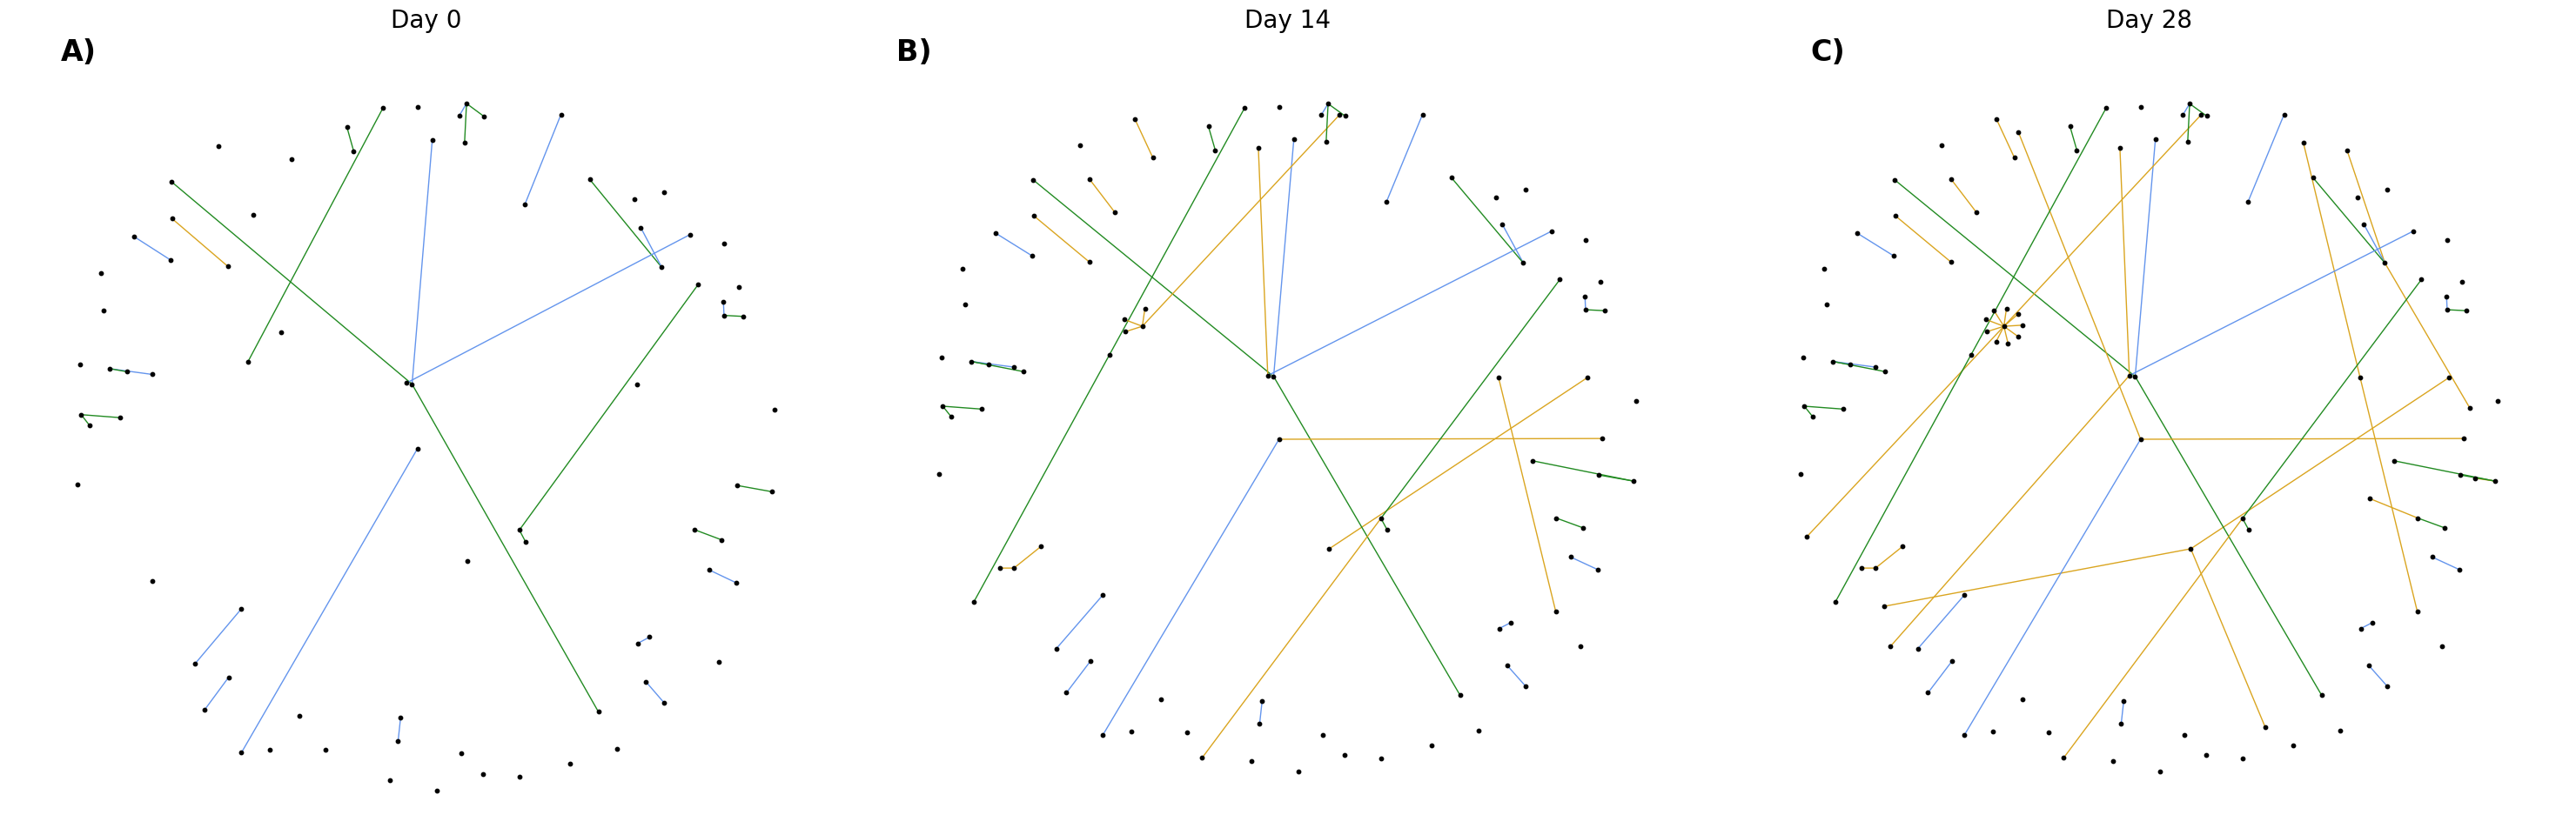

In [13]:
edge_colors0 = ['cornflowerblue' if e['rel_type']=="Main" else 'forestgreen' if e['rel_type'] == "Casual" else 'goldenrod' for u,v,k,e in G0.edges(keys=True,data=True)]
edge_colors14 = ['cornflowerblue' if e['rel_type']=="Main" else 'forestgreen' if e['rel_type'] == "Casual" else 'goldenrod' for u,v,k,e in G14.edges(keys=True,data=True)]
edge_colors28 = ['cornflowerblue' if e['rel_type']=="Main" else 'forestgreen' if e['rel_type'] == "Casual" else 'goldenrod' for u,v,k,e in G28.edges(keys=True,data=True)]

layout28 = nx.spring_layout(G28, seed = 0)

fig = plt.figure(figsize=(30, 10))
gs = GridSpec(1, 3)  # 2/3 height for graphs, 1/3 height for tables

# Create subplots for network graphs
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])

# Turn off axes for graphs
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')

# Plot the graphs
ax0.set(title='Day 0')
nx.draw_networkx(G0, pos=layout28, with_labels=False, node_size=10, edge_color=edge_colors0, 
                 arrows=False, node_color='black', ax=ax0)
ax1.set(title='Day 14')
nx.draw_networkx(G14, pos=layout28, with_labels=False, node_size=10, edge_color=edge_colors14, 
                 arrows=False, node_color='black', ax=ax1)
ax2.set(title='Day 28')
nx.draw_networkx(G28, pos=layout28, with_labels=False, node_size=10, edge_color=edge_colors28, 
                 arrows=False, node_color='black', ax=ax2)

fig.text(0.03, 0.92, 'A)', va='center', fontweight = 'bold', fontsize = 24)
fig.text(0.35, 0.92, 'B)', va='center', fontweight = 'bold', fontsize = 24)
fig.text(0.7, 0.92, 'C)', va='center', fontweight = 'bold', fontsize = 24)

# Adjust layout
plt.tight_layout()

plt.savefig("cumulative_edges.png", dpi = 600, bbox_inches = "tight")



# Function to create tables below subplots
def create_table(data, row_labels):
    col_labels = ["Relationship Type", "Edges"]
    table_data = list(zip(row_labels, data))
    print(table_data)

# Table data
row_labels = ["Main", "Casual", "One-time", "Total"]
table_G0 = [row_labels, counts_G0]
table_G14 = [row_labels, counts_G14]
table_G28 = [row_labels, counts_G28]

# Add tables below each graph
create_table(counts_G0, row_labels)
create_table(counts_G14, row_labels)
create_table(counts_G28, row_labels)